In [1]:
!pip install amazon-textract-textractor[pdfium]==1.8.2 --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [66]:
!pip install sagemaker --quiet
import os
os.environ["AWS_PROFILE"] = "arlnocaj+robotarmgenai-Admin"
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [67]:
import sagemaker

# Get the SageMaker session and default bucket
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print(f"Default sagemaker bucket: {default_bucket}")

Default sagemaker bucket: sagemaker-us-east-1-339712707214


In [88]:
#download a pdf from a url if required
sample_paper_url = "https://arxiv.org/pdf/2404.10630"
!wget -O ./data/my_document.pdf {sample_paper_url} --no-check-certificate

--2024-08-26 10:09:47--  https://arxiv.org/pdf/2404.10630
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.67.42, 151.101.195.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362915 (1.3M) [application/pdf]
Saving to: ‘./data/my_document.pdf’

./data/my_document. 100%[===================>]   1.30M  6.30MB/s    in 0.2s    

2024-08-26 10:09:48 (6.30 MB/s) - ‘./data/my_document.pdf’ saved [1362915/1362915]



In [89]:
# copy data folder with sample pdf files to S3
!aws s3 sync ./data s3://{default_bucket}/data

upload: data/paper-llm-training-sample.pdf to s3://sagemaker-us-east-1-339712707214/data/paper-llm-training-sample.pdf
upload: data/my_document.pdf to s3://sagemaker-us-east-1-339712707214/data/my_document.pdf


In [90]:
document = "data/paper-llm-training-sample.pdf"
#document = "data/my_document.pdf"
document_s3_url = f"s3://{default_bucket}/{document}"

In [91]:
from textractor import Textractor
from textractor.data.constants import TextractFeatures
from textractor.data.text_linearization_config import TextLinearizationConfig

extractor = Textractor()
document = extractor.start_document_analysis(
    document_s3_url,    
    features=[TextractFeatures.LAYOUT, TextractFeatures.FORMS, TextractFeatures.TABLES],
    save_image=True,
)

In [92]:
document

## Using Layout Analysis

Try the [interactive Textract Demo for layout analysis](https://us-east-1.console.aws.amazon.com/textract/home?region=us-east-1#/demo) in the AWS Console.


## Using Amazon Textract Textractor Library

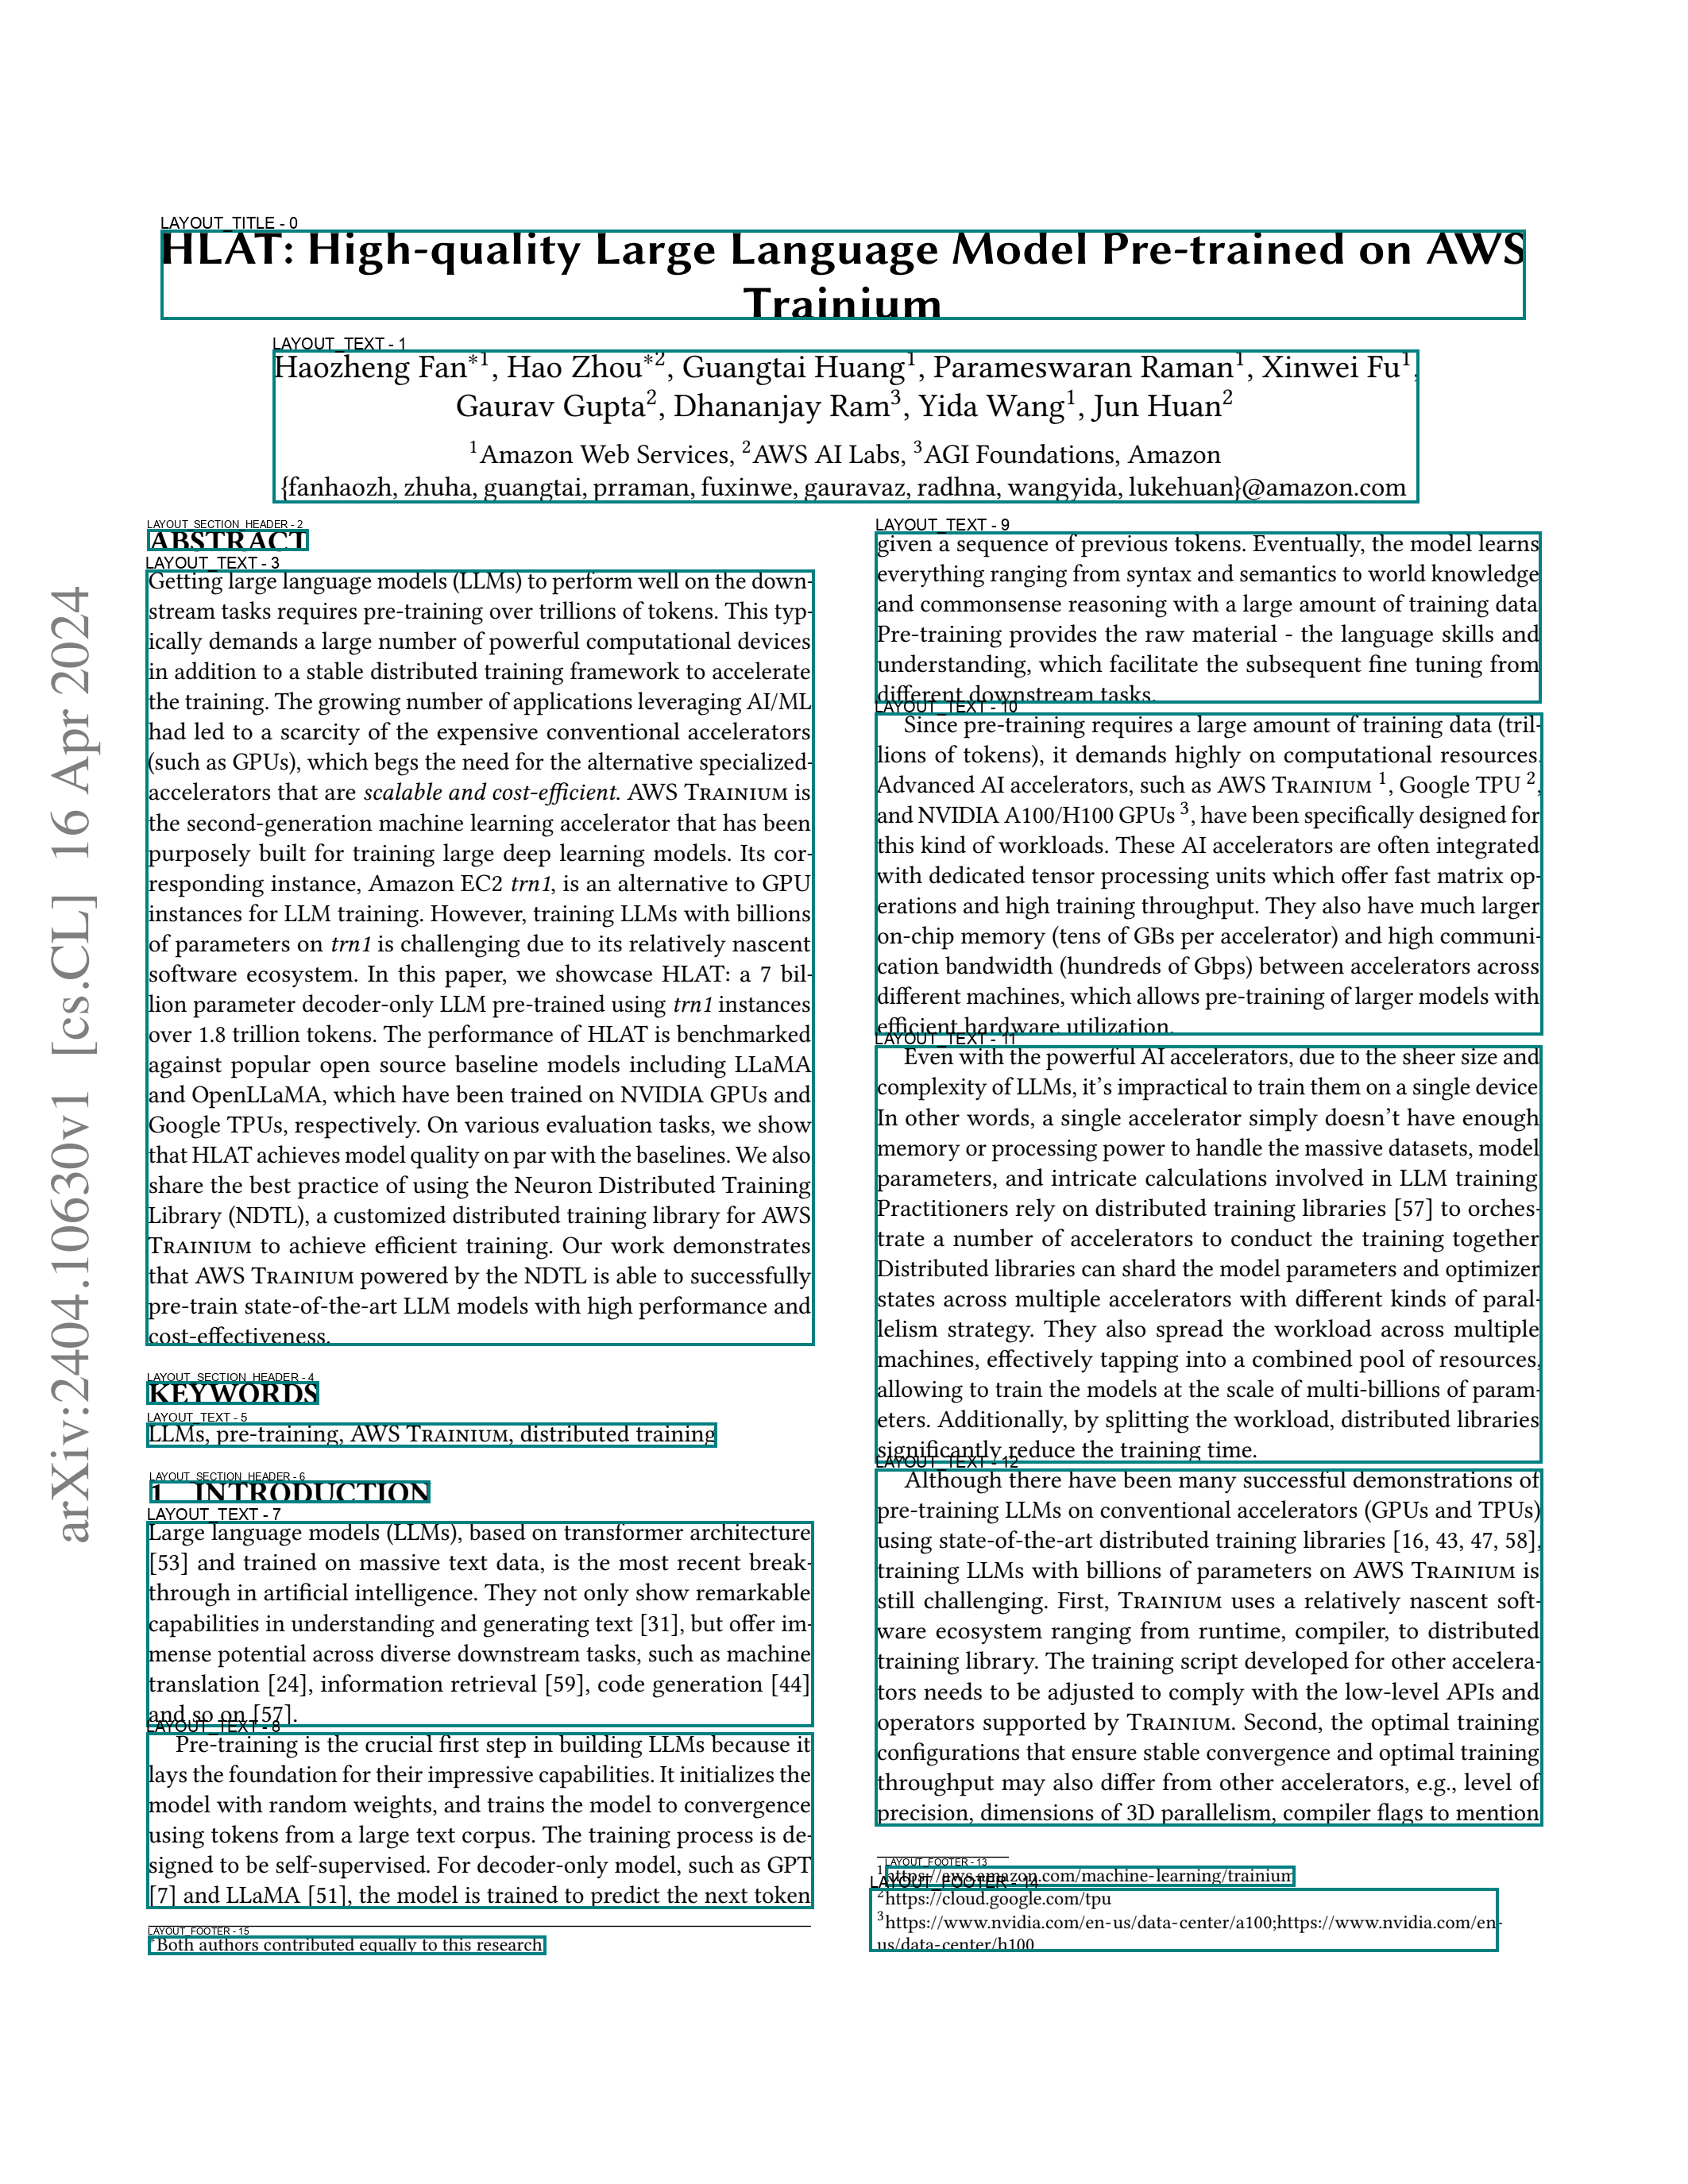

In [118]:
# visualize first page of document
document.pages[0].layouts.visualize(with_text=True, with_words=False).convert("RGB")

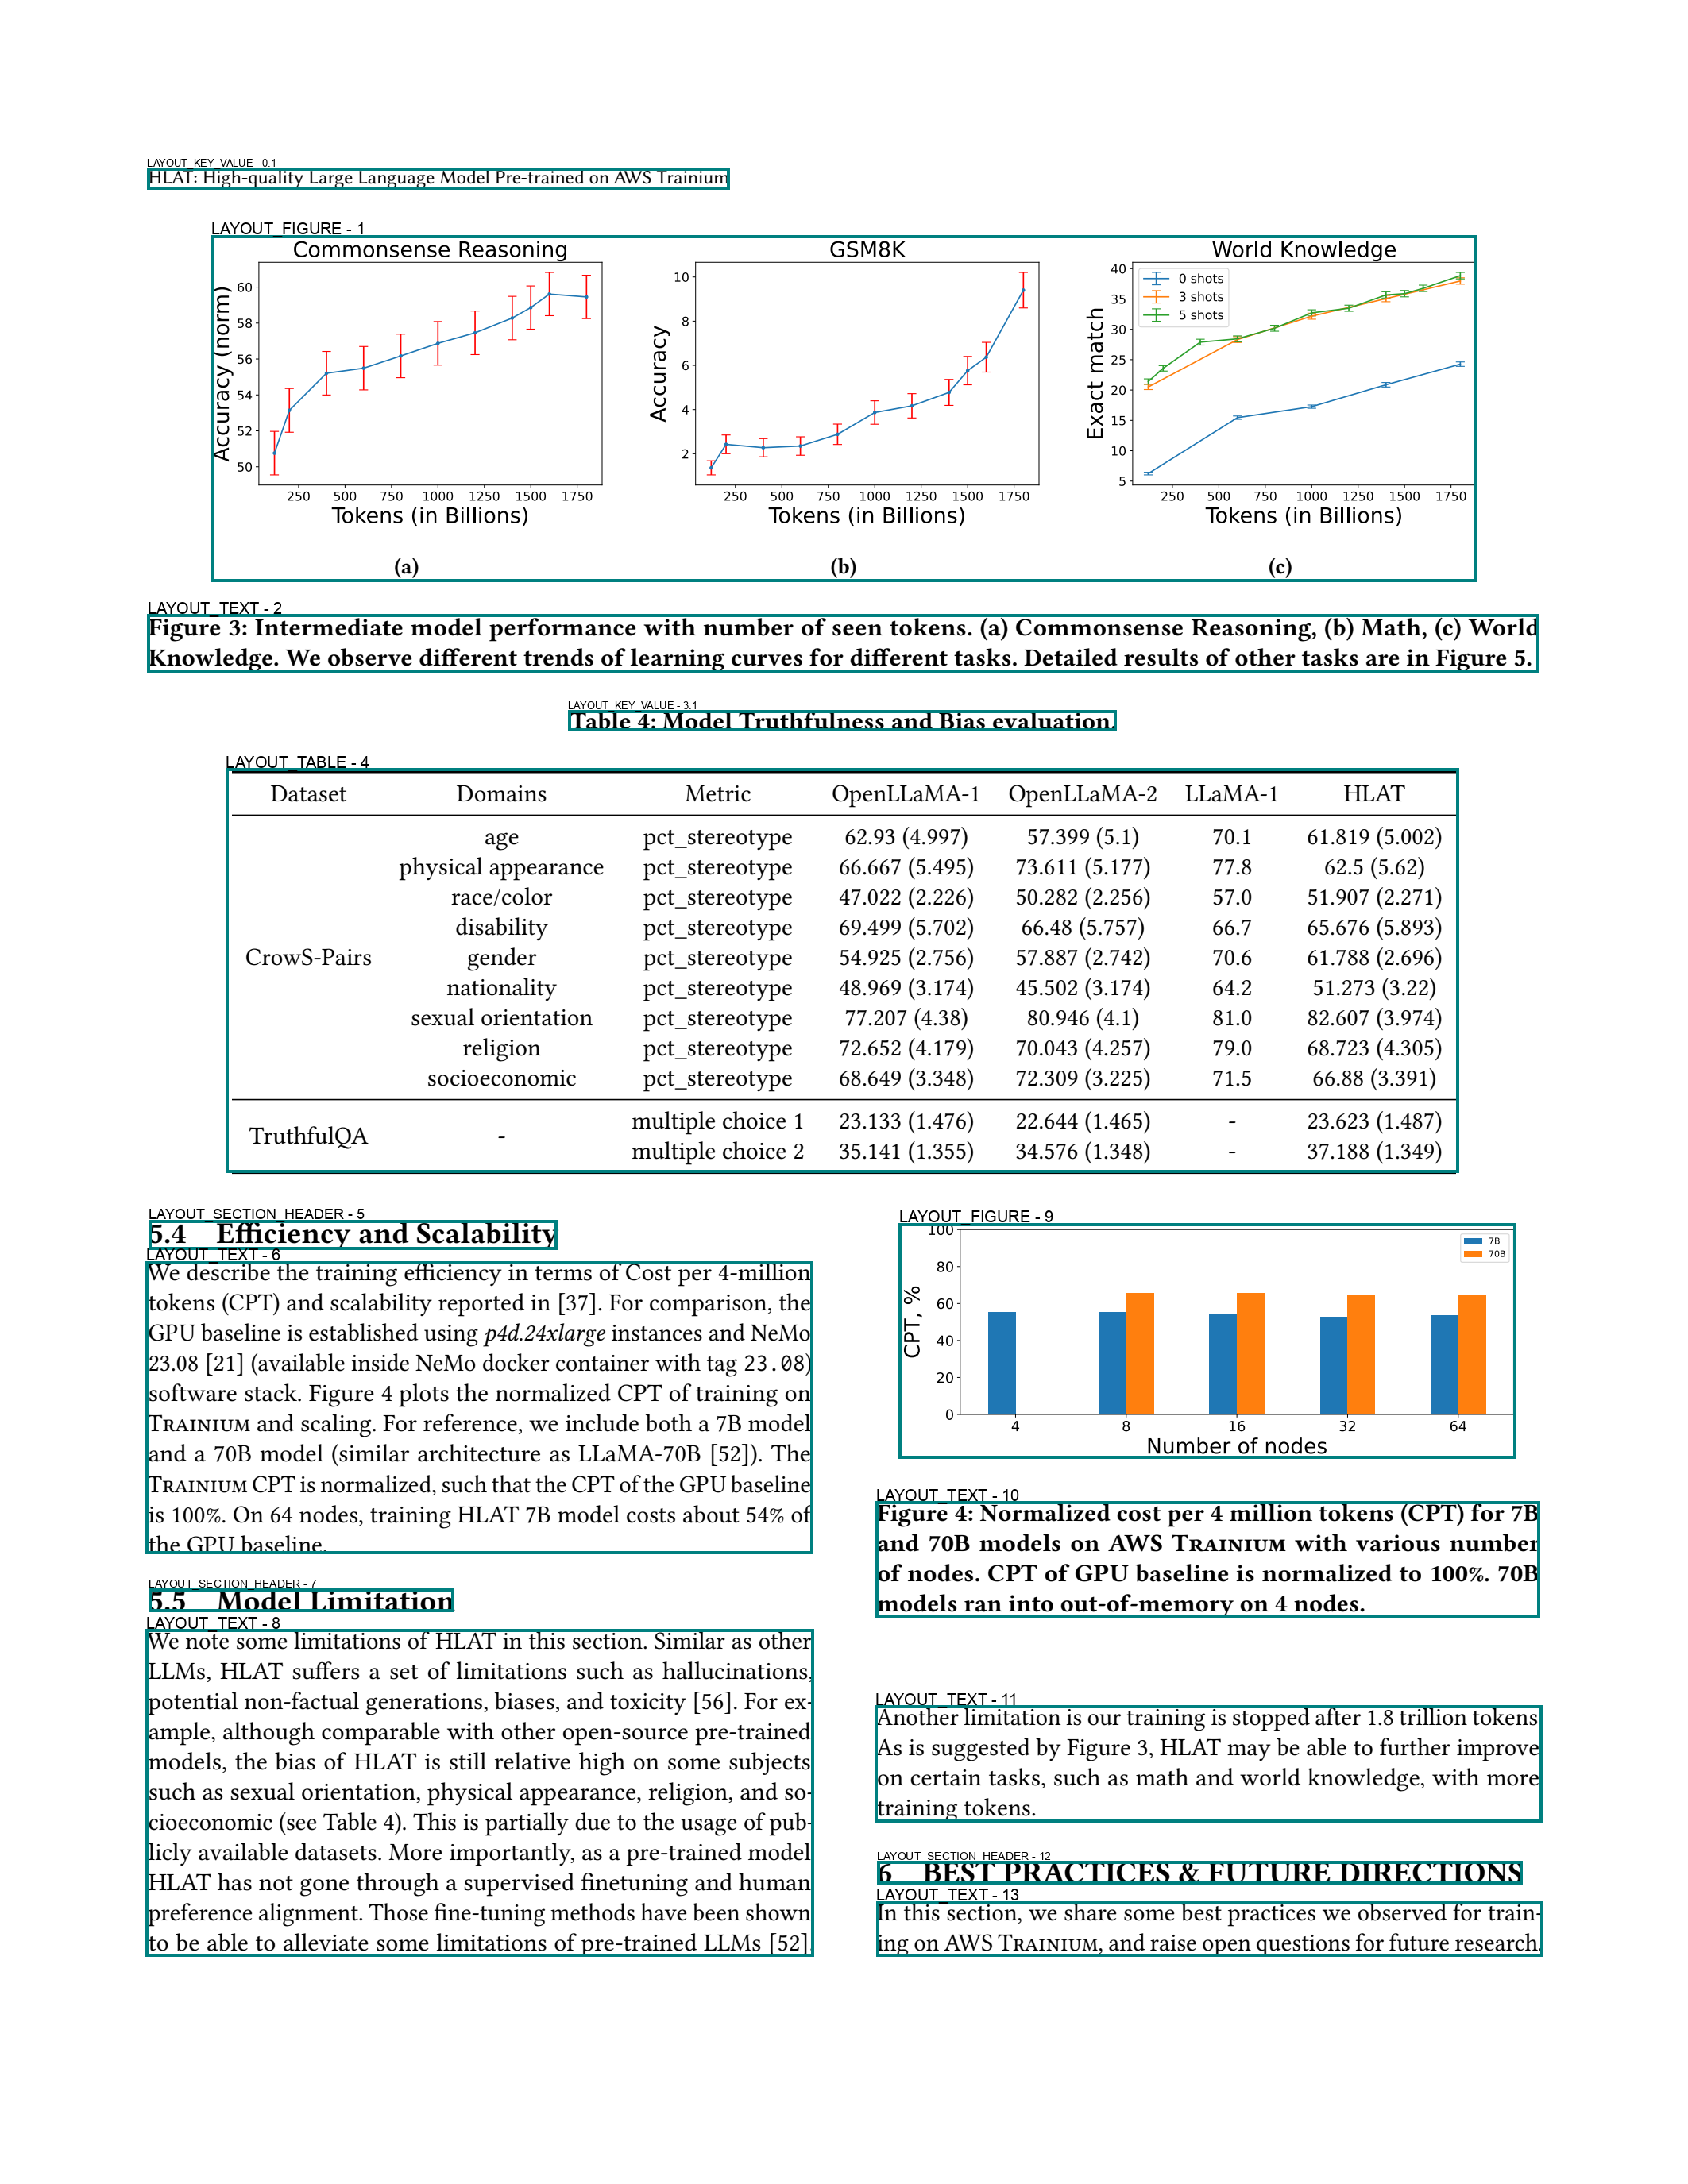

In [119]:
# visualize the layout of another page
document.pages[6].layouts.visualize(with_text=True, with_words=False).convert("RGB")

In [126]:
# Show the table as proper pandas DataFrame with headers etc.
document.tables[2].to_pandas(use_columns=True)

Task  Shots                  Metric      OpenLLaMA-1   \
0                   MMLU      5                accuracy   30.552 (3.432)    
1                    BBH      3   multiple choice grade   35.535 (1.864)    
2  Commonsense Reasoning      0                accuracy   55.587 (1.203)    
3                             0         accuracy (norm)   58.411 (1.201)    
4        World Knowledge      5             exact match   38.942 (0.532)    
5  Reading Comprehension      0                accuracy   70.459 (0.798)    
6                   Math      8                accuracy     5.08 (0.605)    
7                   Code      0                  pass@1             4.77    
8                             0                 pass@10            12.83    
9                             0                pass@100            23.78    

      OpenLLaMA-2  LLaMA-1  LLaMA-2             HLAT   
0  41.075 (3.611)     35.1     45.3   41.318 (3.602)   
1  35.502 (1.861)     30.3     32.6   36.565 (1.845)   
2  56.893 (1.195)        -        -   56.152 (1.194)   
3   61.262 (1.19)    67.3*    67.5*   59.455 (1.206)   
4   37.023 (0.52)    46.2*    48.9*   38.846 (0.534)   
5  72.416 (0.782)     76.5     77.4   72.508 (0.781)   
6   5.231 (0.613)     11.0     14.6    9.401 (0.804)   
7            9.06     10.5     12.8             7.62   
8           23.58        -        -            19.83   
9           40.24     36.5     45.6            34.15

## Converting to HTML
<a id='convert_to_html'></a>

In [13]:
# helper to limit the height in our view
def wrapped_html(html):
    full_html = f"""
    <div style="max-height: 500px; overflow-y: auto;">
        {html}
    </div>
    """
    return full_html

In [14]:
from IPython.display import display, HTML

html= document.to_html()
display(HTML(wrapped_html(html)))

## Converting to Markdown
<a id='convert_to_md'></a>

In [15]:
from IPython.display import display, Markdown
from ipywidgets import widgets, Layout

def display_markdown_with_max_height(markdown_text, max_height='300px'):
    html_content = f"""
    <div style="max-height: {max_height}; overflow-y: auto;">    
    <pre style="margin: 0;">{Markdown(markdown_text).data}</pre>    
    </div>
    """
    display(HTML(html_content))

long_markdown = document.to_markdown()
display_markdown_with_max_height(long_markdown, max_height='300px')

## Layout-aware Chunking <a id='layout_chunking'></a>


Lets first consider the text blocks (paragraphs) as initial chunking units. Each text block is combined with its previous title and section header. 

The main steps are
* Linearize each unit using the semantic layout information.
* For each chunk (paragraph) add relevant layout metadata to each chunk like, page_number, bounding_box, title, section, etc.
* For Figures: Extend them for semantic indexing
  * Option 1: Describe figures, images, diagrams using e.g. Claude 3 vision, and add this description as textual metadata field or as separate chunk
  * Option 2: Embed figures, images, diagrams directly using [Titan Image Embeddings](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html)

The result is an ordered list of chunks with all semantic layout information from the document to improve information retrieval.

### Create dataframe with chunks and raw metadata

In [127]:
import pandas as pd

rows = []
for layout in document.layouts:        
    row = {}    
    row["layout_type"] = layout.layout_type
    row["page"] = layout.page
    row["confidence"] = layout.confidence
    row["reading_order"] = layout.reading_order
    row["text"] = layout.get_text()
    row["words"] = layout.words
    # row["bbox"] = layout.bbox
    row["id"] = layout.id
    row.update(layout.bbox.__dict__)
    row["layout"] = layout
    row["raw_object"] = layout.raw_object
        
    del row["spatial_object"]    
    rows.append(row)    

df = pd.DataFrame(rows)

df

layout_type  page  confidence  reading_order  \
0             LAYOUT_TITLE     1    0.713867            0.0   
1              LAYOUT_TEXT     1    0.490234            1.0   
2    LAYOUT_SECTION_HEADER     1    0.969238            2.0   
3              LAYOUT_TEXT     1    0.965820            3.0   
4    LAYOUT_SECTION_HEADER     1    0.835449            4.0   
..                     ...   ...         ...            ...   
140  LAYOUT_SECTION_HEADER    10    0.940918           33.0   
141            LAYOUT_TEXT    10    0.975586           34.0   
142  LAYOUT_SECTION_HEADER    10    0.923828           35.0   
143            LAYOUT_TEXT    10    0.966797           36.0   
144          LAYOUT_FOOTER    10    0.623535           37.0   

                                                  text  \
0     HLAT: High-quality Large Language Model Pre-t...   
1    Haozheng Fan*1, Hao Zhou*2 Guangtai Huang1 Par...   
2                                            ABSTRACT    
3    Getting large language models (LLMs) to perfor...   
4                                            KEYWORDS    
..                                                 ...   
140  B EVALUATION RESULTS ON INTERMEDIATE CHECKPOINTS    
141  In Table 6 we list the evaluation results of H...   
142                    C NEURON NEMO MEGATORN PACKAGE    
143  We also experimented on AWS Neuron Nemo Megatr...   
144  10 https://awsdocs-neuron.readthedocs-hosted.c...   

                                                 words  \
0    [HLAT:, High-quality, Large, Language, Model, ...   
1    [Haozheng, Fan*1,, Hao, Zhou*2, Guangtai, Huan...   
2                                           [ABSTRACT]   
3    [Getting, large, language, models, (LLMs), to,...   
4                                           [KEYWORDS]   
..                                                 ...   
140  [B, EVALUATION, RESULTS, ON, INTERMEDIATE, CHE...   
141  [In, Table, 6, we, list, the, evaluation, resu...   
142               [C, NEURON, NEMO, MEGATORN, PACKAGE]   
143  [We, also, experimented, on, AWS, Neuron, Nemo...   
144  [10, https://awsdocs-neuron.readthedocs-hosted...   

                                       id     width    height         x  \
0    77992928-26e4-4374-829e-7cbf7bc35b30  0.808515  0.041284  0.095165   
1    08151d77-898e-4de4-86fa-2e51739d7cf6  0.679195  0.070040  0.161424   
2    ada1f8b4-5f6c-4302-90f4-9ac391834f36  0.095758  0.010076  0.087245   
3    41beb243-b7b3-4599-b3bd-61e583bc8223  0.396307  0.355211  0.086220   
4    33981a12-d344-45db-8d0a-471e75032888  0.101833  0.010524  0.086953   
..                                    ...       ...       ...       ...   
140  32c92a49-9735-4781-adc6-15ef7d158d56  0.392659  0.026649  0.519043   
141  f2f2f37f-269d-4161-8736-0ea8d7d02b7f  0.395610  0.053221  0.518692   
142  8754ef22-a564-410b-8084-1e7e0d9b6d33  0.359845  0.010474  0.519382   
143  449ef34b-431d-4336-8f29-c40aec34f050  0.395856  0.081973  0.518186   
144  7b091a96-6190-4e3e-ba7c-9f975067385b  0.362837  0.020511  0.518741   

            y                                             layout  \
0    0.105198  <textractor.entities.layout.Layout object at 0...   
1    0.160205  <textractor.entities.layout.Layout object at 0...   
2    0.242227  <textractor.entities.layout.Layout object at 0...   
3    0.260800  <textractor.entities.layout.Layout object at 0...   
4    0.632657  <textractor.entities.layout.Layout object at 0...   
..        ...                                                ...   
140  0.399944  <textractor.entities.layout.Layout object at 0...   
141  0.434796  <textractor.entities.layout.Layout object at 0...   
142  0.501512  <textractor.entities.layout.Layout object at 0...   
143  0.518634  <textractor.entities.layout.Layout object at 0...   
144  0.874469  <textractor.entities.layout.Layout object at 0...   

                                            raw_object  
0    {'BlockType': 'LAYOUT_TITLE', 'Confidence': 71...  
1    {'BlockType': 'LAYOUT_TEXT'

In [129]:
# Show the detected type of layout blocks
set(df["layout_type"].values)

{'LAYOUT_FIGURE',
 'LAYOUT_FOOTER',
 'LAYOUT_HEADER',
 'LAYOUT_KEY_VALUE',
 'LAYOUT_LIST',
 'LAYOUT_SECTION_HEADER',
 'LAYOUT_TABLE',
 'LAYOUT_TEXT',
 'LAYOUT_TITLE'}

### Forward fill chunks with metadata (LAYOUT_TITLE, LAYOUT_SECTION_HEADER)

In [133]:
# add header/section columns and rolling fill the chunks with the upper value of header/section
def forward_fill_column(df, col_name, header_value):
    # Step 1: Create a boolean mask for LAYOUT_HEADER rows
    header_mask = df[col_name] == header_value
    # Step 2: Create a new column 'header_value' initialized with NaN
    df[header_value] = pd.NA
    # Step 3: Set value for mask
    df.loc[header_mask, header_value] = df.loc[header_mask, 'text']
    # Step 4: Forward fill the header values
    df[header_value] = df[header_value].ffill()    
    # Step 5: Set 'header_value' to NaN for LAYOUT_HEADER rows
    df.loc[header_mask, header_value] = pd.NA
    return df

# df = forward_fill_column(df, "layout_type","LAYOUT_HEADER")
df = forward_fill_column(df, "layout_type","LAYOUT_TITLE")
df = forward_fill_column(df, "layout_type","LAYOUT_SECTION_HEADER")
df[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","text"]].head(20)

layout_type                                       LAYOUT_TITLE  \
0            LAYOUT_TITLE                                               <NA>   
1             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
2   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
3             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
4   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
5             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
6   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
7             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
8             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
9             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
10            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
11            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
12            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
13          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
14          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
15          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
16          LAYOUT_HEADER   HLAT: High-quality Large Language Model Pre-t...   
17            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
18            LAYOUT_LIST   HLAT: High-quality Large Language Model Pre-t...   
19  LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   

   LAYOUT_SECTION_HEADER  page  \
0                   <NA>     1   
1                   <NA>     1   
2                   <NA>     1   
3              ABSTRACT      1   
4                   <NA>     1   
5              KEYWORDS      1   
6                   <NA>     1   
7        1 INTRODUCTION      1   
8        1 INTRODUCTION      1   
9        1 INTRODUCTION      1   
10       1 INTRODUCTION      1   
11       1 INTRODUCTION      1   
12       1 INTRODUCTION      1   
13       1 INTRODUCTION      1   
14       1 INTRODUCTION      1   
15       1 INTRODUCTION      1   
16       1 INTRODUCTION      2   
17       1 INTRODUCTION      2   
18       1 INTRODUCTION      2   
19                  <NA>     2   

                                                 text  
0    HLAT: High-quality Large Language Model Pre-t...  
1   Haozheng Fan*1, Hao Zhou*2 Guangtai Huang1 Par...  
2                                           ABSTRACT   
3   Getting large language models (LLMs) to perfor...  
4                                           KEYWORDS   
5   LLMs, pre-training, AWS TRAINIUM, distributed ...  
6                                     1 INTRODUCTION   
7   Large language models (LLMs), based on transfo...  
8   Pre-training is the crucial first step in buil...  
9   given a sequence of previous tokens. Eventuall...  
10  Since pre-training requires a large amount of ...  
11  Even with the powerful AI accelerators, due to...  
12  Although there have been many successful demon...  
13  https://aws.amazon.com/machine-learning/traini...  
14  'https://cloud.google.com/tpu\n https://www.nv...  
15  *Both authors contributed equally to this rese...  
16  Haozheng Fan, Hao Zhou, Guangtai Huang, Parame...  
17  a few. On the other hand, Amazon EC2 trn1 inst...  
18  We pre-train HLAT (High-quality LLM pre-traine...  
19   2 BACKGROUND - DISTRIBUTED TRAINING ON TRAINIUM

layout_type  page  confidence  reading_order  \
71   LAYOUT_FIGURE     5    0.952637            1.0   
75   LAYOUT_FIGURE     5    0.969727            5.0   
97   LAYOUT_FIGURE     7    0.906250            1.0   
105  LAYOUT_FIGURE     7    0.886230            9.0   

                                                  text  \
71   2.2\nTraining loss\nGradient norm\nLearning ra...   
75   \n103 797 \n\n102\n89\n\n25\n\n10 \n7 \n\n2 \n...   
97   GSM8K\nWorld Knowledge\n\nCommonsense Reasonin...   
105  100\n\n7B\n 70B\n\n80\n\n60\n\n40\n\n20\n\n0\n...   

                                                 words  \
71   [2.2, Training, loss, Gradient, norm, Learning...   
75   [103, 797, 102, 89, 25, 10, 7, 2, 1, 1, 10°, 1...   
97   [GSM8K, World, Knowledge, Commonsense, Reasoni...   
105  [100, 7B, 70B, 80, 60, 40, 20, 0, 4, 8, 16, 32...   

                                       id     width    height         x  \
71   51d762f4-9a4b-4c27-9071-0ee69f326217  0.782429  0.126318  0.109031   
75   ee61b70e-7ec1-4d80-8e2d-e8a3c76266cc  0.364275  0.109633  0.101850   
97   b42c720e-c0fd-4121-af96-36d99dc73976  0.750283  0.158734  0.124969   
105  50e0c926-93f7-4004-bdf6-bf4b438e81cc  0.365409  0.107543  0.532636   

            y                                             layout  \
71   0.107397  <textractor.entities.layout.Layout object at 0...   
75   0.569435  <textractor.entities.layout.Layout object at 0...   
97   0.107780  <textractor.entities.layout.Layout object at 0...   
105  0.560179  <textractor.entities.layout.Layout object at 0...   

                                            raw_object  \
71   {'BlockType': 'LAYOUT_FIGURE', 'Confidence': 9...   
75   {'BlockType': 'LAYOUT_FIGURE', 'Confidence': 9...   
97   {'BlockType': 'LAYOUT_FIGURE', 'Confidence': 9...   
105  {'BlockType': 'LAYOUT_FIGURE', 'Confidence': 8...   

                                          LAYOUT_TITLE  \
71    HLAT: High-quality Large Language Model Pre-t...   
75    HLAT: High-quality Large Language Model Pre-t...   
97    HLAT: High-quality Large Language Model Pre-t...   
105   HLAT: High-quality Large Language Model Pre-t...   

          LAYOUT_SECTION_HEADER  
71                5 EVALUATION   
75                5 EVALUATION   
97   5.3 Truthfulness and Bias   
105       5.5 Model Limitation

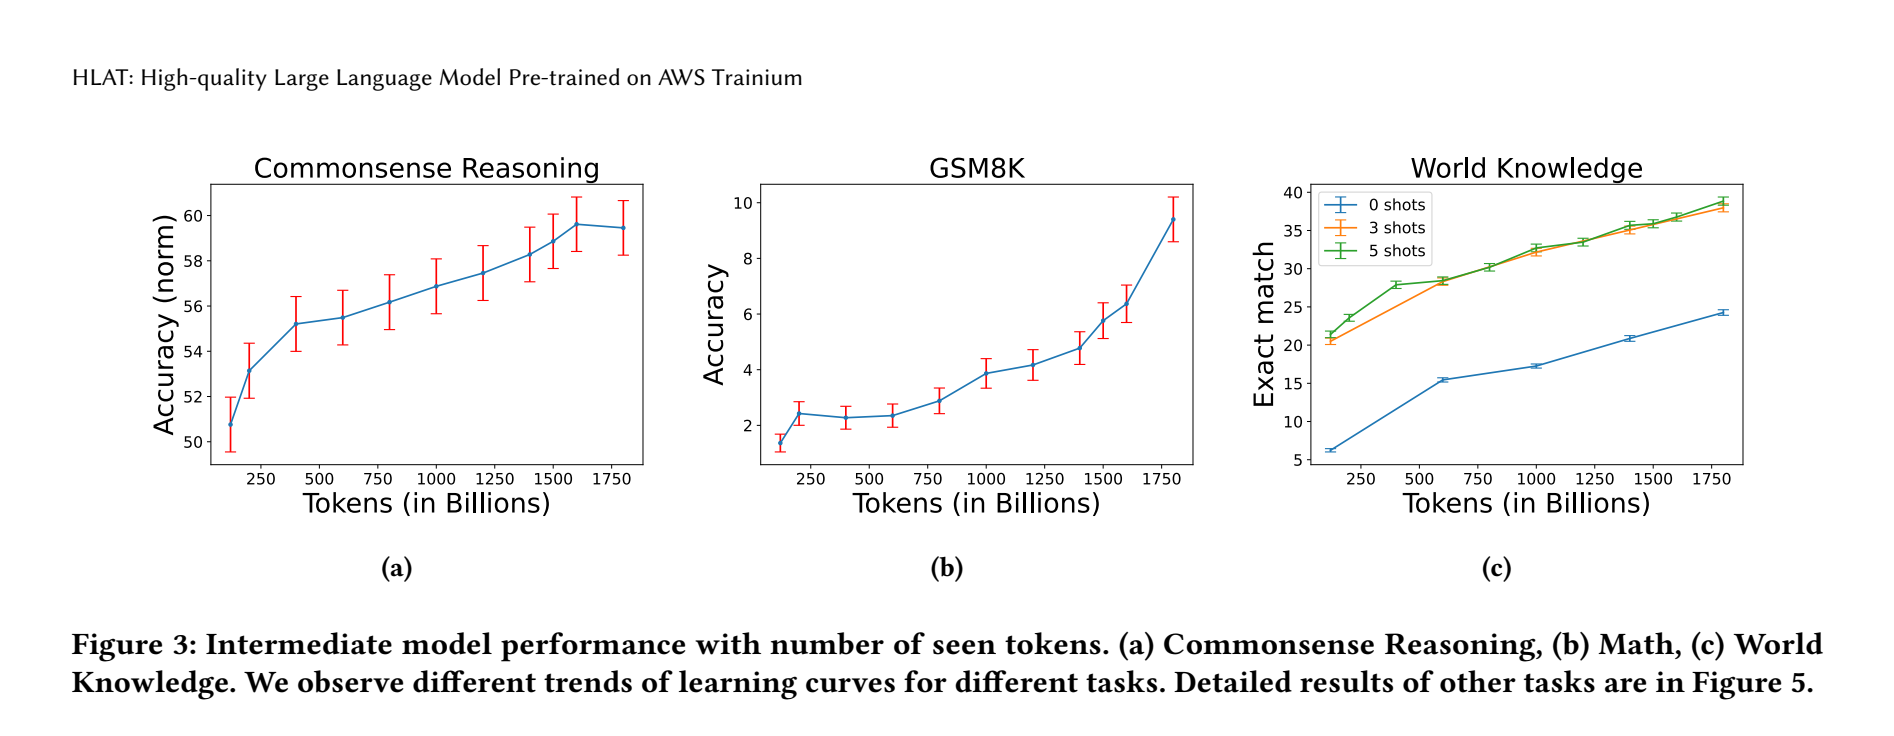

In [144]:
# visualize a detected and cropped figure
df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
layout = df_figures["layout"].values[2]
def crop_image(layout):
    bbox = layout.bbox
    image = bbox.spatial_object.image
    img_width = image.width
    img_height = image.height
    delta = 150
    image_cut = image.crop((
        int(bbox.x*img_width)-delta, 
        int(bbox.y*img_height)-delta, 
        int((bbox.x+bbox.width)*img_width+delta), 
        int((bbox.y+bbox.height)*img_height+delta)))
    return image_cut

cropped_image = crop_image(layout)
cropped_image

In [ ]:
### Extend figures with semantic description using Claude 3.5 vision

In [166]:
# code to call Claude Vision with image and get the description of the image
import boto3
import base64
from io import BytesIO
bedrock = boto3.client('bedrock-runtime')
import boto3, json

session = boto3.Session()
bedrock = session.client(service_name='bedrock-runtime')

def encode_image(img):    
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return buffered.getvalue()

def describe_image_bedrock(img):
    image_bytes = encode_image(img)
    message_list = []        
    image_message = {
        "role": "user",
        "content": [
            { "text": "Image 1:" },
            {
                "image": {
                    "format": "png",
                    "source": {
                        "bytes": image_bytes #no base64 encoding required!
                    }
                }
            },
            { "text": "Describe the following image accurately so that it is useful for information retrieval with maximum 500 characters." }
        ],
    }
    
    message_list.append(image_message)
    
    response = bedrock.converse(
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        messages=message_list,
        inferenceConfig={
            "maxTokens": 2000,
            "temperature": 0
        },
    )
    response_message = response['output']['message']
    return response_message

response_message = describe_image_bedrock(cropped_image)
print(json.dumps(response_message["content"], indent=4))

[
    {
        "text": "The image shows three line graphs titled (a) Commonsense Reasoning, (b) GSM8K, and (c) World Knowledge, depicting the performance of a large language model (HLAT) pre-trained on AWS Trainium across different numbers of tokens (in billions) on the x-axis. The y-axes represent accuracy/metric scores. The graphs illustrate varying learning curve trends for different tasks as the model is exposed to more data. The caption provides details about the intermediate model performance with increasing token counts."
    }
]


In [163]:
# iterate over all chunks and add figure description if a figure exists
def generate_extended_description(row):
    if row['layout_type'] == 'LAYOUT_FIGURE':
        if len(row["figure_desc"])>0: return row["figure_desc"]
        cropped_image = crop_image(row.layout)
        response_message = describe_image_bedrock(cropped_image)
        description = response_message["content"][0]["text"]
        return description
    else:
        return ""
    
from tqdm import tqdm
tqdm.pandas()

df['figure_desc'] = df.progress_apply(generate_extended_description, axis=1)
df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
df_figures[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","text","figure_desc"]].head(20)

100%|██████████| 145/145 [00:00<00:00, 16598.18it/s]


layout_type                                       LAYOUT_TITLE  \
71   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
75   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
97   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
105  LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   

          LAYOUT_SECTION_HEADER  page  \
71                5 EVALUATION      5   
75                5 EVALUATION      5   
97   5.3 Truthfulness and Bias      7   
105       5.5 Model Limitation      7   

                                                  text  \
71   2.2\nTraining loss\nGradient norm\nLearning ra...   
75   \n103 797 \n\n102\n89\n\n25\n\n10 \n7 \n\n2 \n...   
97   GSM8K\nWorld Knowledge\n\nCommonsense Reasonin...   
105  100\n\n7B\n 70B\n\n80\n\n60\n\n40\n\n20\n\n0\n...   

                                           figure_desc  
71   The image shows four line plots depicting the ...  
75   The image is a bar graph titled "Figure 2: Num...  
97   The image shows three line graphs titled (a) C...  
105  The image presents a bar chart comparing the n...

In [ ]:
## Create final text chunks with markdown tables

In [165]:
config = TextLinearizationConfig(table_linearization_format='markdown')
chunk_values = []


for i, row in df.iterrows():        
    chunk_text, chunk_words = row.layout.get_text_and_words(config)
    
    prefix = ""
    if not pd.isna(row.LAYOUT_SECTION_HEADER):
        prefix = f"# {row.LAYOUT_SECTION_HEADER}\n\n"            
    chunk_text_final = prefix + chunk_text
    
    if row.layout_type == "LAYOUT_FIGURE":
        # get additional description using vision llm        
        chunk_text_final = prefix + f"{row.figure_desc}\n\n Keywords:{chunk_text}"
    # if row.layout_type == "LAYOUT_TABLE":
    #     # optionally, summarize or describe table to find more easily        
        
    chunk_values.append(chunk_text_final)
    
df["chunk_text"] = chunk_values 

df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
df_figures[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","chunk_text"]].head(10)

layout_type                                       LAYOUT_TITLE  \
71   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
75   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
97   LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   
105  LAYOUT_FIGURE   HLAT: High-quality Large Language Model Pre-t...   

          LAYOUT_SECTION_HEADER  page  \
71                5 EVALUATION      5   
75                5 EVALUATION      5   
97   5.3 Truthfulness and Bias      7   
105       5.5 Model Limitation      7   

                                            chunk_text  
71   # 5 EVALUATION \n\nThe image shows four line p...  
75   # 5 EVALUATION \n\nThe image is a bar graph ti...  
97   # 5.3 Truthfulness and Bias \n\nThe image show...  
105  # 5.5 Model Limitation \n\nThe image presents ...

### Next Steps after Chunking

The next step is to index the chunks using semantic text embedding, e.g. with [Amazon Bedrock Knowledge Bases](https://docs.aws.amazon.com/bedrock/latest/userguide/kb-how-it-works.html) 